In [1]:
import numpy as np
from matplotlib import pyplot as plt

from astroML.classification import GMMBayes
from astroML.utils import split_samples, completeness_contamination
from astroML.plotting.tools import draw_ellipse

from sklearn.metrics import roc_curve

from astropy.table import Table

# Read in the data 

In [2]:
# Load the cross-matched HLC-NSC catalog
hlc_nsc = Table(np.load('data/hlc_nsc_half_arcsec.npy'))
# Load the QSO training sample
qso = Table(np.load('data/hlc_nsc_sdss_qso_matches.npy'))
# Load the standard stars training sample 
stars = Table(np.load('data/hlc_nsc_sdss_stars_matches.npy'))

In [3]:
def fetch_dr14_quasars(qso):
    # SDSS DR14 QSO cross-matched to HLC-NSC catalog 
    # --> signal / noise > 5 
    m_g_sn = qso['HLCgmag'] / qso['HLCgerr'] > 5
    m_u_sn = qso['HLCumag'] / qso['HLCuerr'] > 5
    m_r_sn = qso['HLCrmag'] / qso['HLCrerr'] > 5
    m_redshift = qso['Z'] < 2.5

    m = m_g_sn * m_u_sn * m_r_sn  * m_redshift
    print('We select ', np.sum(m), ' of ', len(m))
    quasars = qso[m]
    return quasars

def fetch_standard_stars(stars):
    # STARS
    # --> signal / noise > 5 
    m_g_sn = stars['HLCgmag'] / stars['HLCgerr'] > 5
    m_u_sn = stars['HLCumag'] / stars['HLCuerr'] > 5
    m_r_sn = stars['HLCrmag'] / stars['HLCrerr'] > 5

    m =  m_g_sn * m_u_sn* m_r_sn
    print('We select ', np.sum(m), ' of ', len(m))
    stars = stars[m]
    return stars

def make_dereddened_colors(table):
    # Make column with HLC dereddened magnitudes 
    filters = 'ugriz'
    for f in filters : 
        table['HLC'+f+'mag_dered'] = table['HLC'+f+'mag'] - table['HLC'+f+'RED']

    # Make column with HLC colors based on dereddened magnitudes
    for i in range(len(filters)-1):
        f1,f2 = filters[i], filters[i+1]
        table['HLC'+f1+'-'+f2] = table['HLC'+f1+'mag_dered']-table['HLC'+f2+'mag_dered']
        
make_dereddened_colors(hlc_nsc)
make_dereddened_colors(stars)
make_dereddened_colors(qso)

quasars =  fetch_dr14_quasars(qso)
stars = fetch_standard_stars(stars)

/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/astropy/table/column.py:928: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, oper)(other)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


We select  7250  of  22205
We select  260872  of  693857


In [4]:
# stack colors into matrix X : it is the training set 
# size : ( number of qso + number of stars ) * ( number of colors )
Nqso = len(quasars)
Nstars = len(stars)
X = np.empty((Nqso + Nstars, 4), dtype=float)

X[:Nqso, 0] = quasars['HLCu-g']
X[:Nqso, 1] = quasars['HLCg-r']
X[:Nqso, 2] = quasars['HLCr-i']
X[:Nqso, 3] = quasars['HLCi-z']

X[Nqso:, 0] = stars['HLCu-g']
X[Nqso:, 1] = stars['HLCg-r']
X[Nqso:, 2] = stars['HLCr-i']
X[Nqso:, 3] = stars['HLCi-z']

# Make a vector with labels 
y = np.zeros(Nqso + Nstars, dtype=int)
y[:Nqso] = 1  # 1 = qso ,  0 = star 

# split into training and test sets
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.9, 0.1],
                                                     random_state=0)


# Get a fitted classifier 

### Fit it to train data but predict it for test data

In [5]:
classifier = GMMBayes(n_components=5, min_covar=1E-5, covariance_type='full')
classifier.fit(X_train, y_train)

predictions = classifier.predict_proba(X_test)
y_prob = predictions[:, 1]

/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/skle

/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/uti

/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/uti

# Plot the results of the fits and ROC curves

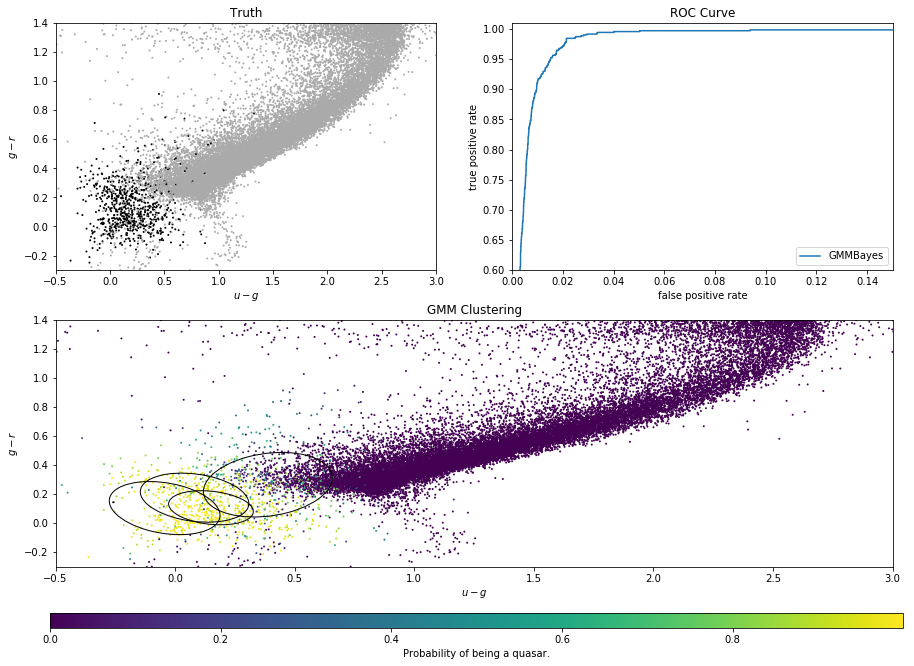

In [6]:
plt.figure(figsize=(15,10))


#####################################################################################
############################# TRUE RESULTS ##########################################
#####################################################################################

ax = plt.subplot(221)

im = plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=4, linewidths=0, edgecolors='none', cmap=plt.cm.binary)
im.set_clim(-0.5, 1)

ax.set_xlim(-0.5, 3.0)
ax.set_ylim(-0.3, 1.4)
ax.set_xlabel('$u - g$')
ax.set_ylabel('$g - r$')
ax.set_title("Truth")


#####################################################################################
#############################     ROC      ##########################################
#####################################################################################
ax = plt.subplot(222)

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
ax.plot(fpr, tpr, label="GMMBayes")

ax.legend(loc=4)
ax.set_xlabel('false positive rate')
ax.set_ylabel('true positive rate')
ax.set_xlim(0, 0.15)
ax.set_ylim(0.6, 1.01)
ax.set_title("ROC Curve")


#####################################################################################
############################  PREDICTIONS  ##########################################
#####################################################################################
ax = plt.subplot(212)

im = plt.scatter(X_test[:, 0], X_test[:, 1], c=y_prob, s=4, edgecolors="None")
ax.set_xlim(-0.5, 3.0)
ax.set_ylim(-0.3, 1.4)
ax.set_xlabel('$u - g$')
ax.set_ylabel('$g - r$')
ax.set_title("GMM Clustering")

#which gmms is it?
for i in range(classifier.n_components[0]):
    mean = classifier.gmms_[1].means_[i]
    cov = classifier.gmms_[1].covars_[i]
    if cov.ndim == 1:
        cov = np.diag(cov)
    draw_ellipse(mean, cov, ax=plt.gca(), scales=[1], fc='none', ec='black', zorder=2)

# colorbars man....
cbar_ax = plt.gcf().add_axes(([0.12, 0.04, 0.79, 0.02]))
plt.colorbar(im, cax=cbar_ax, orientation="horizontal", label="Probability of being a quasar.")

plt.show()

# Get classification correctness per color dimension

/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/skle

/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/uti

/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/uti

/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: Depr

/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/uti

/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/uti

/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/skle

/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/uti

/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/uti

/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/py

/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/uti

/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/uti

completeness [ 0.90168539  0.90308989  0.9002809   0.90308989]
contamination [ 0.28187919  0.28156425  0.28219485  0.28076063]


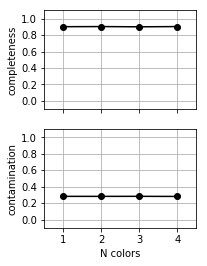

In [7]:
predictions = []
Ncolors = np.arange(1, X.shape[1] + 1)

#order = np.array([1, 0, 2, 3])

for nc in Ncolors:
    clf = GMMBayes(n_components=5, min_covar=1E-5, covariance_type='full')
    clf.fit(X_train[:, :nc], y_train)
    y_pred = clf.predict(X_test[:, :nc])

    classifiers.append(clf)
    predictions.append(y_pred)

completeness, contamination = completeness_contamination(predictions, y_test)

print("completeness", completeness)
print("contamination", contamination)

# Plot completeness vs Ncolors
ax = plt.subplot(222)
ax.plot(Ncolors, completeness, 'o-k', ms=6)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.NullFormatter())

ax.set_ylabel('completeness')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

# Plot contamination vs Ncolors
ax = plt.subplot(224)
ax.plot(Ncolors, contamination, 'o-k', ms=6)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))

ax.set_xlabel('N colors')
ax.set_ylabel('contamination')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)
plt.show()

# Classification correctness per number of components

/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/skle

/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/uti

/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/uti

/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/uti

/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/uti

/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/skle

/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/uti

/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/uti

/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/uti

/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/uti

/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/uti

/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/uti

/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/uti

/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/py

/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/uti

/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/uti

/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/uti

/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/uti

/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/uti

/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: Depr

/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/skle

/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/uti

/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/uti

/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/uti

/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


completeness [ 0.28230337  0.78932584  0.7752809   0.76685393  0.90168539  0.91151685
  0.89747191  0.89044944  0.87219101  0.88342697  0.87640449  0.87780899
  0.87219101  0.89044944]
contamination [ 0.39820359  0.50133097  0.34128878  0.22881356  0.28107503  0.27808676
  0.25697674  0.24613555  0.19559585  0.20979899  0.19794344  0.21383648
  0.19559585  0.20151134]


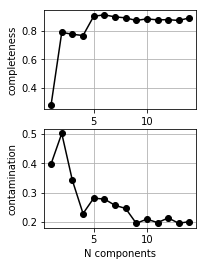

In [7]:
predictions = []
classifiers = []
bic = []
Ncomponents = range(1, 15)

for nc in Ncomponents:
    clf = GMMBayes(n_components=nc, min_covar=1E-5, covariance_type='full')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    classifiers.append(clf)
    predictions.append(y_pred)
    bic.append(clf.)
    
    
completeness, contamination = completeness_contamination(predictions, y_test)

print("completeness", completeness)
print("contamination", contamination)

# Plot completeness vs Ncomponents
ax = plt.subplot(222)
ax.plot(Ncomponents, completeness, 'o-k', ms=6)

ax.set_ylabel('completeness')
ax.grid(True)

# Plot contamination vs Ncomponents
ax = plt.subplot(224)
ax.plot(Ncomponents, contamination, 'o-k', ms=6)

ax.set_xlabel('N components')
ax.set_ylabel('contamination')
ax.grid(True)

plt.show()

# I don't really get what BIC and AIC should be

/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/dino/.conda/envs/DSFP/lib/python3.6/site-packages/sklearn/uti

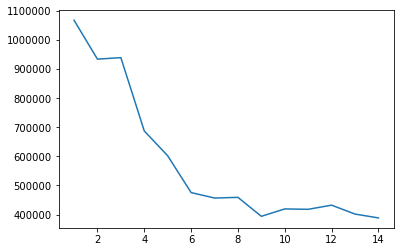

In [15]:
bic = []
for c in classifiers:
    m = c.gmms_[1]
    bic.append(m.bic(X_test))
    
plt.plot(Ncomponents, bic)
plt.show()